🚀 INITIALIZING PILOT 2: FAST-TRACK RISK MAPPING
   ✅ AI Model Loaded.
   Processing Maps (1 pixel for every 5)...
   Aligning Satellite to Terrain...
   🧠 AI Predicting Fuel Load...
   🔥 Calculating Heatmap...


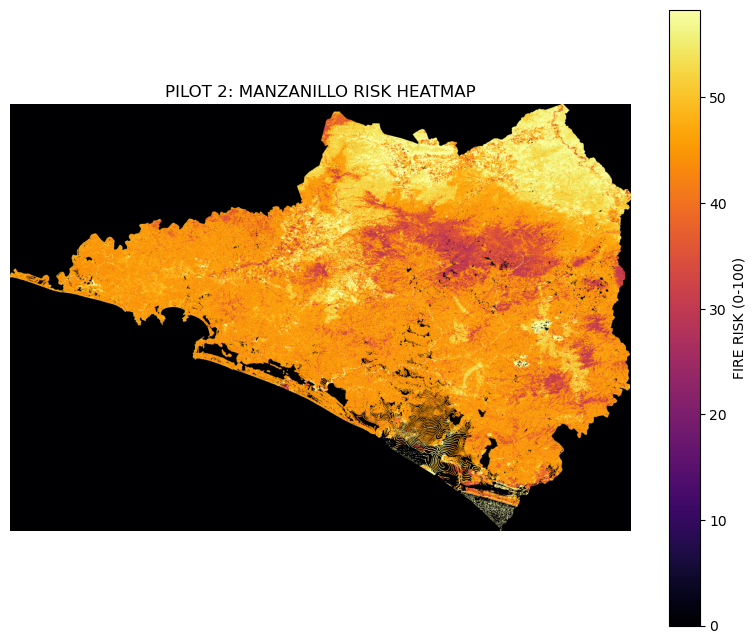

✅ SUCCESS. Map generated.


In [1]:
import rasterio
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
from scipy.ndimage import zoom

# --- CONFIGURATION ---
model_path = "../models/manzanillo_biomass_model.joblib"
inegi_path = "../data/raw/inegi_cem/Colima_r15m.tif"
sentinel_dir = "../data/raw/sentinel/"
sentinel_zip = [f for f in os.listdir(sentinel_dir) if f.endswith('.zip')][0]
zip_path = os.path.join(sentinel_dir, sentinel_zip)

print("🚀 INITIALIZING PILOT 2: FAST-TRACK RISK MAPPING")

# 1. LOAD MODEL
model = joblib.load(model_path)
print("   ✅ AI Model Loaded.")

# 2. LOAD & DOWNSAMPLE LAYERS
# We read the maps but immediately slice them [::5] to reduce size by 25x
sample_rate = 5 

print(f"   Processing Maps (1 pixel for every {sample_rate})...")

with rasterio.open(inegi_path) as src:
    # Read only every 5th pixel
    dem = src.read(1)[::sample_rate, ::sample_rate]
    
    # Calculate Slope on this smaller map
    px, py = src.res
    px, py = px * sample_rate, py * sample_rate # Adjust resolution
    dy, dx = np.gradient(dem, -py, px)
    slope_rad = np.arctan(np.sqrt(dx**2 + dy**2))
    slope = np.degrees(slope_rad)

# Load NDVI (Satellite)
with zipfile.ZipFile(zip_path, 'r') as z:
    red_file = [f for f in z.namelist() if "B04" in f and "10m" in f][0]
    nir_file = [f for f in z.namelist() if "B08" in f and "10m" in f][0]
    
    with rasterio.open(f"/vsizip/{zip_path}/{red_file}") as r: 
        # Resize Sentinel to match the DEM's shape
        # We read full then resize because random access in zip is slow
        red = r.read(1)
        
    with rasterio.open(f"/vsizip/{zip_path}/{nir_file}") as n: 
        nir = n.read(1)

# Resize Satellite to match the DEM shape EXACTLY
print("   Aligning Satellite to Terrain...")
zoom_y = dem.shape[0] / red.shape[0]
zoom_x = dem.shape[1] / red.shape[1]
red_small = zoom(red, (zoom_y, zoom_x), order=0)
nir_small = zoom(nir, (zoom_y, zoom_x), order=0)

# Calc NDVI
num = (nir_small - red_small).astype(float)
den = (nir_small + red_small).astype(float)
ndvi = np.divide(num, den, out=np.zeros_like(num), where=den!=0)

# 3. PREDICT
print("   🧠 AI Predicting Fuel Load...")
input_df = pd.DataFrame({
    'Elevation_m': dem.flatten(),
    'Slope_deg': slope.flatten(),
    'NDVI': ndvi.flatten()
}).fillna(0)

pred_biomass = model.predict(input_df)
biomass_map = pred_biomass.reshape(dem.shape)

# 4. RISK SCORE
# Risk = (Biomass * Slope) / (NDVI + 0.2)
print("   🔥 Calculating Heatmap...")
risk_map = (biomass_map * slope) / (ndvi + 0.2)
risk_map = np.where(risk_map < 0, 0, risk_map)
# Normalize 0-100
risk_map = (risk_map / np.max(risk_map)) * 100

# 5. PLOT
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(risk_map, cmap='inferno', vmin=0, vmax=np.percentile(risk_map, 98))
plt.colorbar(im, label="FIRE RISK (0-100)")
ax.set_title("PILOT 2: MANZANILLO RISK HEATMAP")
ax.axis('off')
plt.show()

print(f"✅ SUCCESS. Map generated.")